<a href="https://colab.research.google.com/github/nadya1462/sirius_2022/blob/main/Investigation_STDP_2_pictures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Спайковая нейронная сеть на двух нейронах. Бинарная классификация

### Генерация данных

In [ ]:
import numpy as np
from google.colab import drive 
drive.mount('/content/drive')

data_size = 100
noise_sigma = 10 # standard deviation
min_rate = 0
max_rate = 300
# Quadratic intensity
# M = 256
# left_intensity = [((k/9)**2)*M for k in range(10)]
# right_intensity = [((k/9)**2)*M for k in range(9,-1,-1)]
# Exponential intensity
left_intensity = [256, 128, 64, 32, 16, 8, 4, 2, 1, 0]
right_intensity = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256]
ni = len(left_intensity)

data_left_rates = np.empty(shape = [0, ni])
data_right_rates = np.empty(shape = [0, ni])
for _ in range(data_size // 2):
    noise = noise_sigma * np.random.randn(ni)
    data_left_rates = np.vstack([data_left_rates, np.clip(left_intensity + noise, min_rate, max_rate)])
    data_right_rates = np.vstack([data_right_rates, np.clip(right_intensity + noise, min_rate, max_rate)])

file_path_left = 'drive/My Drive/Colab Notebooks/data_left_rates.npy'
file_path_right = 'drive/My Drive/Colab Notebooks/data_right_rates.npy'
np.save(file_path_left, data_left_rates)
np.save(file_path_right, data_right_rates)

Mounted at /content/drive


### Установка и загрузка необходимых пакетов

In [ ]:
!pip install brian2
!pip install --upgrade numpy
!pip install --upgrade matplotlib

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')
import brian2 as b2
import numpy as np
from brian2.monitors.spikemonitor import SpikeMonitor
from brian2.monitors.statemonitor import StateMonitor
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Импорт данных

In [ ]:
file_path_left = 'drive/My Drive/Colab Notebooks/data_left_rates.npy'
file_path_right = 'drive/My Drive/Colab Notebooks/data_right_rates.npy'
with open(file_path_left, 'rb') as f_left:
    data_left_rates = np.load(f_left)
with open(file_path_right, 'rb') as f_right:
    data_right_rates = np.load(f_right)

n_train = 10
train_left_rates = data_left_rates[: n_train // 2]
train_right_rates = data_right_rates[: n_train // 2]
n_test = 20
test_left_rates = data_left_rates[- n_test // 2 :]
test_right_rates = data_right_rates[- n_test // 2 :]

### Модель нейрона

In [ ]:
file_path_weights = 'drive/My Drive/Colab Notebooks/synapses_e_weights.npy'
ni = train_left_rates.shape[1] # number of inputs
min_rate = 0
max_rate = 300

class SNN:

    def __init__(self, ni, train_mode=1):

        # Neurons
        model_n = '''
        dv/dt = ((E_rest_n - v) + g_n * (E_exc_n - v)) / tau_n: volt
        dg_n/dt = -g_n / tau_g_n : 1
        dvt_n/dt = (vt0_n-vt_n) / tc_vt_n * train_mode_n : volt
        tau_n : second
        tau_g_n : second
        E_rest_n : volt
        E_exc_n : volt
        vt0_n : volt
        tc_vt_n : second
        v_rest_n : volt
        v_reset_n : volt
        theta_n : volt
        train_mode_n : 1
        '''
        reset_n = '''
        v=v_reset_n
        vt_n += theta_n * train_mode_n
        '''
        nn = 2
        self.group_n = b2.NeuronGroup(nn, model=model_n, threshold='v>vt_n', reset=reset_n, refractory=5 * b2.ms, method='euler')
        self.group_n.train_mode_n = train_mode
        self.group_n.tau_n = 100 * b2.ms
        self.group_n.tau_g_n = 10 * b2.ms
        self.group_n.E_rest_n = -65 * b2.mV
        self.group_n.E_exc_n = 0 * b2.mV
        self.group_n.vt0_n = -52 * b2.mV
        self.group_n.vt_n = self.group_n.vt0_n
        self.group_n.tc_vt_n = 1e7 * b2.ms
        self.group_n.v_rest_n = -65 * b2.mV
        self.group_n.v_reset_n = -65 * b2.mV
        self.group_n.theta_n = 0.05 * b2.mV
        self.group_n.v = b2.array([-65, -55]) * b2.mV #- 40 * b2.mV

        # EXCISITORY synapses 
        model_e = '''
        dApre/dt = -Apre / taupre : 1 (event-driven)
        dApost/dt = -Apost / taupost : 1 (event-driven)
        w : 1
        gmax : 1
        taupre : second
        taupost : second
        dApre : 1
        dApost : 1
        train_mode_e : 1
        ''' 
        on_pre_e = '''
        g_n_post += w
        Apre += dApre
        w = clip(w + Apost * train_mode_e, 0, gmax)
        '''
        on_post_e = '''
        Apost += dApost
        w = clip(w + Apre * train_mode_e, 0, gmax)
        '''
        self.input_group = b2.PoissonGroup(ni, 0 * b2.Hz, name="input_group")

        self.synapses_e = b2.Synapses(self.input_group, self.group_n, model=model_e, on_pre=on_pre_e, on_post=on_post_e)
        self.synapses_e.connect()
        self.synapses_e.train_mode_e = train_mode
        self.synapses_e.gmax = 0.01 * 28*28 / ni 
        self.synapses_e.taupre = 20 * b2.ms
        self.synapses_e.taupost = self.synapses_e.taupre
        self.synapses_e.dApre = 0.01 
        self.synapses_e.dApost = -self.synapses_e.dApre * self.synapses_e.taupre / self.synapses_e.taupost * 1.05
        self.synapses_e.dApost *= self.synapses_e.gmax
        self.synapses_e.dApre *= self.synapses_e.gmax
        if train_mode:
            self.synapses_e.w = self.synapses_e.gmax / 2
        else:
            with open(file_path_weights, 'rb') as f:
                self.synapses_e.w = np.load(f)

        # INHIBITORY synapses
        model_i = '''
        delta_v_post_i : volt
        ''' 
        on_pre_i = '''
        v_post -= delta_v_post_i
        '''
        self.synapses_i = b2.Synapses(self.group_n, self.group_n, model=model_i, on_pre=on_pre_i)
        self.synapses_i.connect(condition='i != j')
        self.synapses_i.delta_v_post_i = 15 * b2.mV / (nn - 1)

        self.net = b2.Network(self.input_group, self.group_n, self.synapses_e, self.synapses_i)

### Обучение

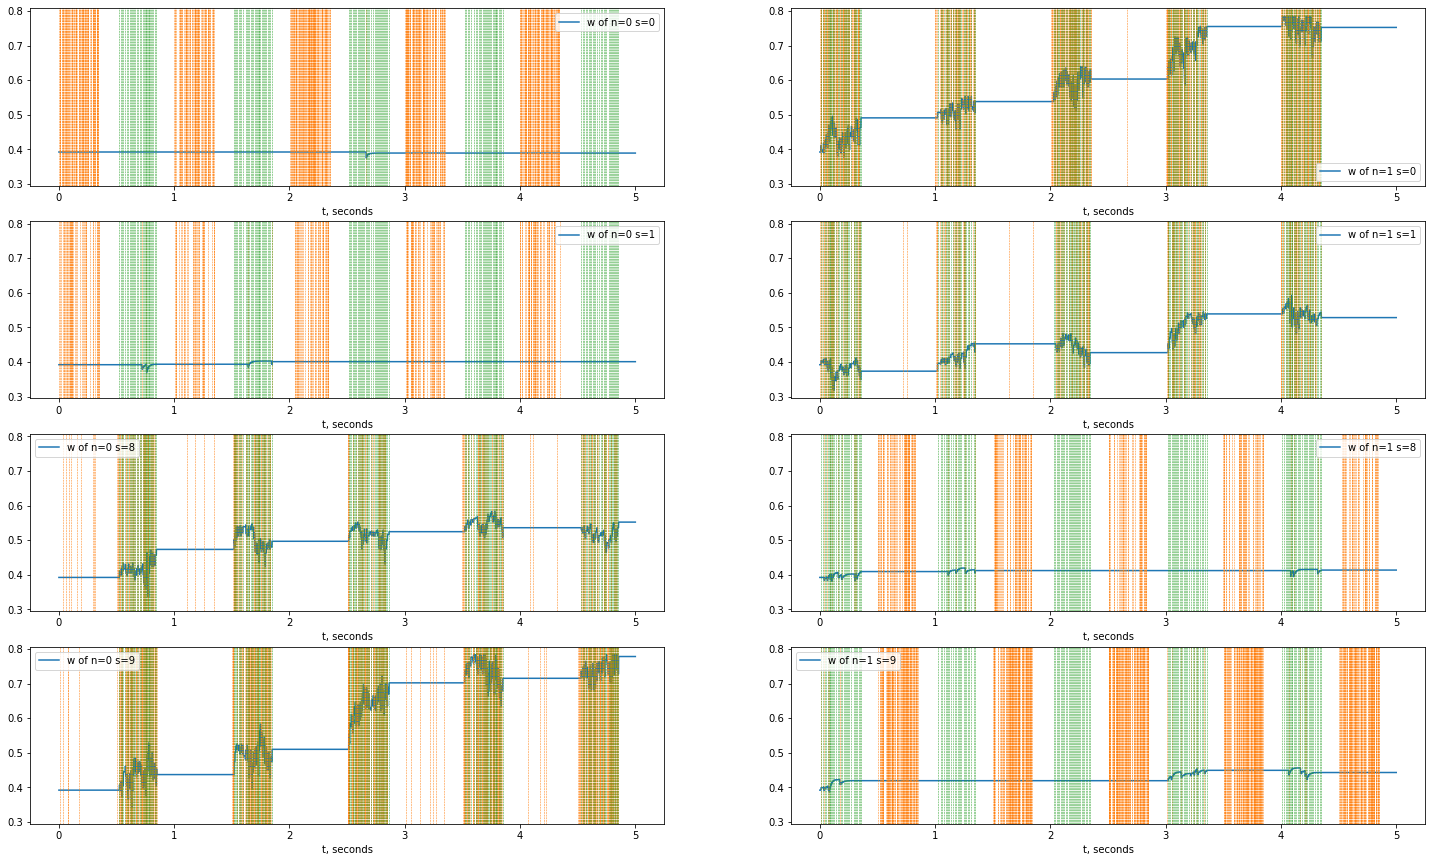

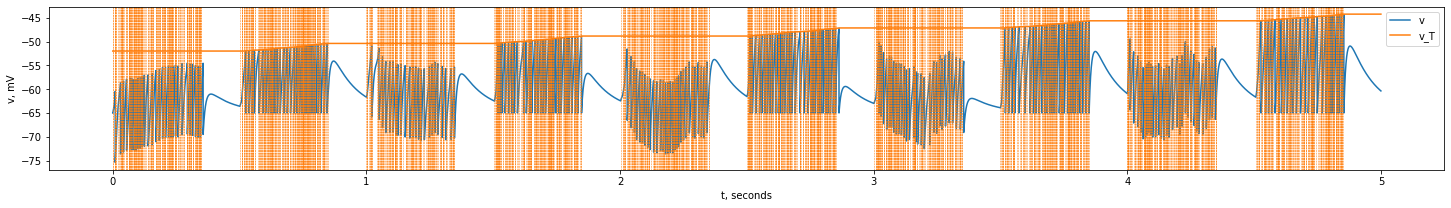

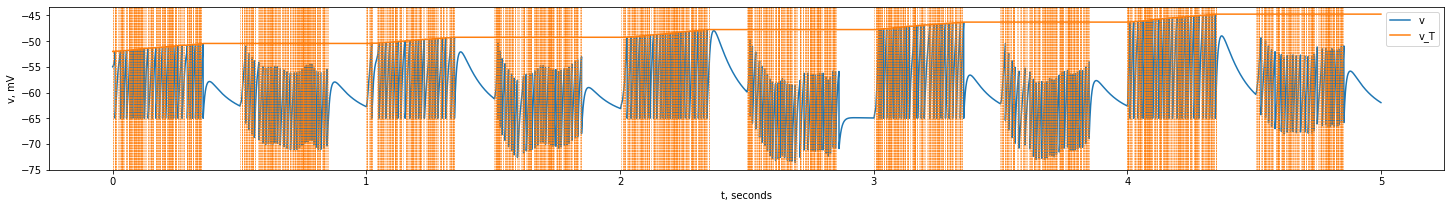

Weights:
[[38. 40. 38. 37. 38. 39. 51. 53. 55. 77.]
 [75. 52. 39. 42. 37. 42. 39. 39. 41. 44.]]


Text(0.5, 1.0, 'Final weights values')

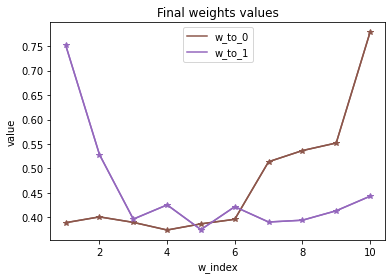

In [ ]:
%matplotlib inline
b2.start_scope()

def show_plots(i_spike_mon, e_state_mon, e_spike_mon, s_state_mon, ind_s):
    NS = min(len(ind_s), 4) 
    NN = 2
    plt.figure(figsize=(25,15))
    for n in range(NN):
        for s in range(NS):
            sp_cell = NS * 100 + NN * 10 + s * NN + n + 1 # subplot coordinate
            if (n==0 and s==0): sp0 = plt.subplot(sp_cell) # make equal scales
            else: plt.subplot(sp_cell, sharex=sp0, sharey=sp0)
            plt.plot(s_state_mon.t/b2.second, s_state_mon.w[ind_s[s] * NN + n] , label='w of n={} s={}'.format(n,ind_s[s]))
            for t in i_spike_mon.spike_trains()[ind_s[s]]:
                plt.axvline(t/b2.second, ls='--', c='C1', lw=0.5) # orange == pre
            for t in e_spike_mon.spike_trains()[n]:
                plt.axvline(t/b2.second, ls='--', c='C2', lw=0.5) # green == post
            plt.legend()
            plt.xlabel("t, seconds")
    #plt.text(-2.0, 2.76, 'Presynaptic spikes: orange', c = "C1", fontsize=18)
    #plt.text(-2.0, 2.70, 'Postsynaptic spikes: green', c = "C2", fontsize=18)
    for n in range(NN):
        plt.figure(figsize=(25,3))
        plt.plot(e_state_mon.t/b2.second, e_state_mon.v[n]/b2.mV, label='v')
        plt.plot(e_state_mon.t/b2.second, e_state_mon.vt_n[n]/b2.mV , label='v_T')
        for t in i_spike_mon.t:
            plt.axvline(t/b2.second, ls='--', c='C1', lw=0.5) # orange == pre
        plt.legend()
        plt.xlabel("t, seconds")
        plt.ylabel("v, mV")
        plt.show()


snn = SNN(ni)

e_state_mon = b2.StateMonitor(snn.group_n, ['v', 'vt_n', 'g_n'], record=True)
s_state_mon = b2.StateMonitor(snn.synapses_e, ['w'], record=True)
i_spike_mon = b2.SpikeMonitor(snn.input_group)
e_spike_mon = b2.SpikeMonitor(snn.group_n)
snn.net.add(e_state_mon)
snn.net.add(s_state_mon)
snn.net.add(i_spike_mon)
snn.net.add(e_spike_mon)

for k in range(n_train // 2):
    snn.input_group.rates = train_left_rates[k] * b2.Hz
    snn.net.run(350 * b2.ms)
    snn.input_group.rates = 0 * b2.Hz
    snn.net.run(150 * b2.ms)
    snn.input_group.rates = train_right_rates[k] * b2.Hz
    snn.net.run(350 * b2.ms)
    snn.input_group.rates = 0 * b2.Hz
    snn.net.run(150 * b2.ms)

ind_syn_to_show = [0,1,8,9]
show_plots(i_spike_mon, e_state_mon, e_spike_mon, s_state_mon, ind_syn_to_show)
snn.net.remove(e_state_mon)
snn.net.remove(s_state_mon)
snn.net.remove(i_spike_mon)
snn.net.remove(e_spike_mon)

np.save(file_path_weights, snn.synapses_e.w)
print("Weights:")
w_to_0 = snn.synapses_e.w[0:19:2]
w_to_1 = snn.synapses_e.w[1:20:2]
print(np.vstack((w_to_0*100//1, w_to_1*100//1)))
plt.plot(np.arange(1,11,1), w_to_0, color = 'C5')
plt.plot(np.arange(1,11,1), w_to_1, color = 'C4')
plt.plot(np.arange(1,11,1), w_to_0, marker = '*', color = 'C5')
plt.plot(np.arange(1,11,1), w_to_1, marker = '*', color = 'C4')
plt.legend(["w_to_0", "w_to_1"])
plt.xlabel("w_index")
plt.ylabel("value")
plt.title("Final weights values")

### Формирование классов 

In [ ]:
def test(rates_sample):
    test_mon = SpikeMonitor(snn.group_n)
    snn.net.add(test_mon)
    snn.input_group.rates = rates_sample * b2.Hz
    snn.net.run(350 * b2.ms)
    snn.input_group.rates = 0 * b2.Hz
    snn.net.run(150 * b2.ms)
    snn.net.remove(test_mon)
    return test_mon.count

snn = SNN(ni, 0)
spike_num_left = np.zeros([2])
spike_num_right = np.zeros([2])
for i in range(4):
    spike_num_left += np.asarray(test(train_left_rates[i]))
    spike_num_right += np.asarray(test(train_right_rates[i]))

classes = {}
if spike_num_left[0] > spike_num_left[1]:
    classes[0] = "left"
    classes[1] = "right"
else:
    classes[0] = "right"
    classes[1] = "left"

print(classes)
print(spike_num_left, spike_num_right)

WARNING    'i' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


{0: 'right', 1: 'left'}
[  1. 192.] [208.   2.]


### Тестирование и анализ результатов

WARNING    'i' is an internal variable of group 'synapses_3', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


----------------------EXPERIMENT 1---------------------------
Mean test rates:
[254. 121.  66.  29.  20.  10.   7.   5.   6.   5.]
[  2.   0.   5.   6.  12.  18.  29.  66. 130. 260.]


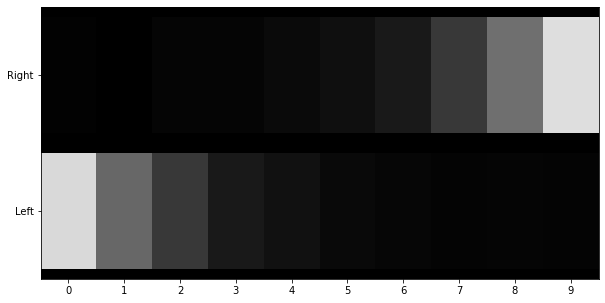

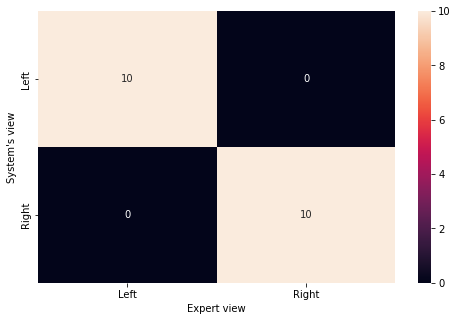

Precision:  1.0
Recall:  1.0
F1_score:  1.0
----------------------EXPERIMENT 2---------------------------
Mean test rates:
[194. 100.  62.  36.  30.  23.  21.  19.  20.  19.]
[ 17.  16.  20.  20.  24.  29.  36.  62. 107. 198.]


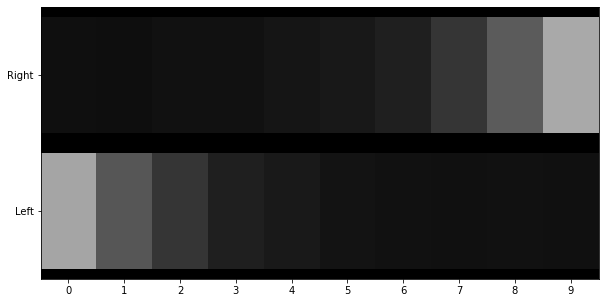

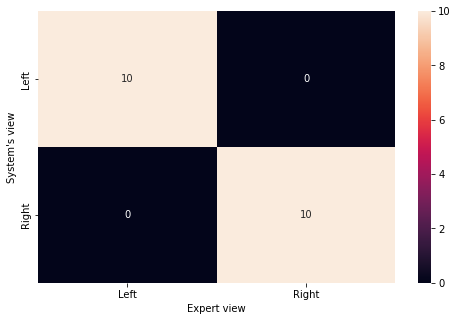

Precision:  1.0
Recall:  1.0
F1_score:  1.0
----------------------EXPERIMENT 3---------------------------
Mean test rates:
[151.  86.  59.  41.  36.  32.  30.  29.  29.  29.]
[ 28.  27.  30.  30.  33.  36.  41.  59.  91. 154.]


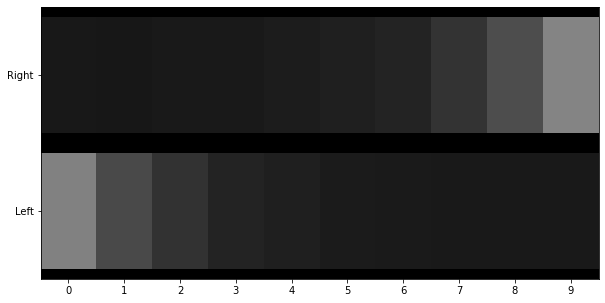

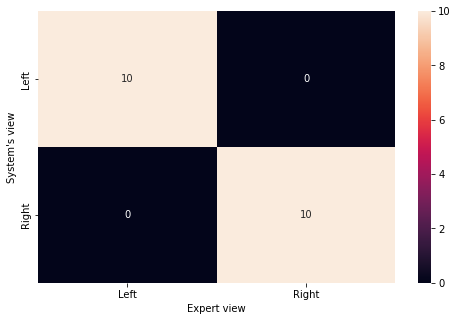

Precision:  1.0
Recall:  1.0
F1_score:  1.0
----------------------EXPERIMENT 4---------------------------
Mean test rates:
[122.  76.  57.  44.  41.  38.  37.  36.  36.  36.]
[ 35.  35.  37.  37.  39.  41.  45.  57.  79. 124.]


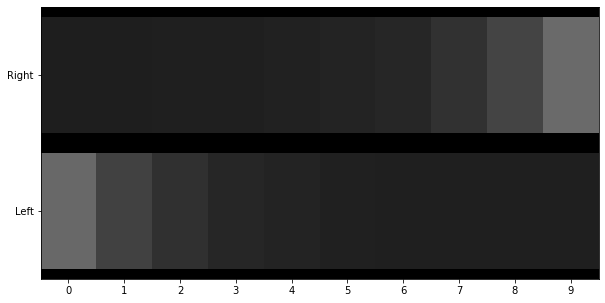

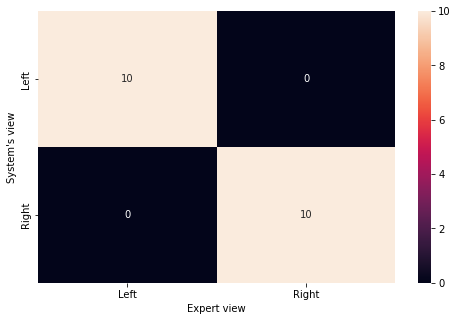

Precision:  1.0
Recall:  1.0
F1_score:  1.0
----------------------EXPERIMENT 5---------------------------
Mean test rates:
[101.  69.  56.  47.  45.  42.  41.  41.  41.  41.]
[ 41.  40.  42.  42.  43.  45.  47.  56.  71. 103.]


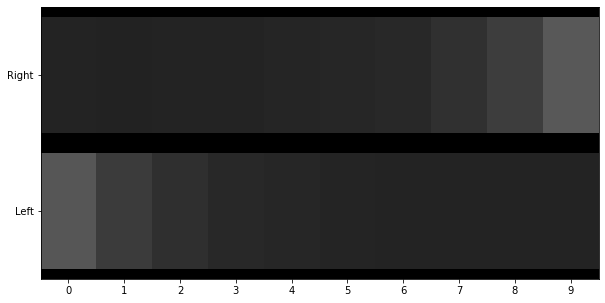

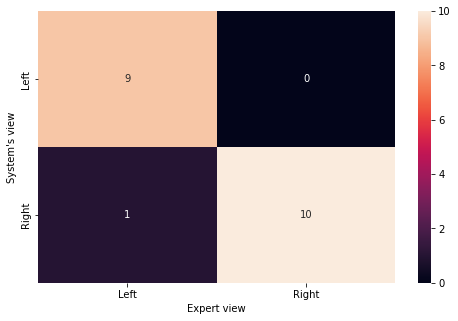

Precision:  0.9545454545454546
Recall:  0.95
F1_score:  0.9522673031026253
----------------------EXPERIMENT 6---------------------------
Mean test rates:
[86. 64. 55. 48. 47. 45. 45. 44. 44. 44.]
[44. 44. 45. 45. 46. 47. 49. 55. 66. 88.]


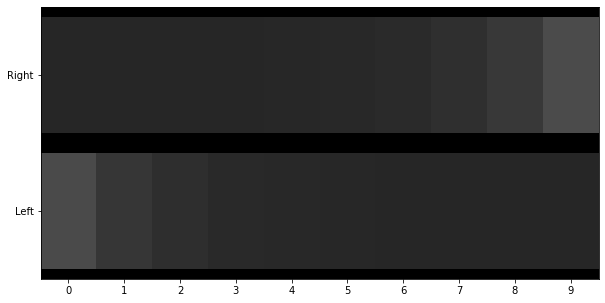

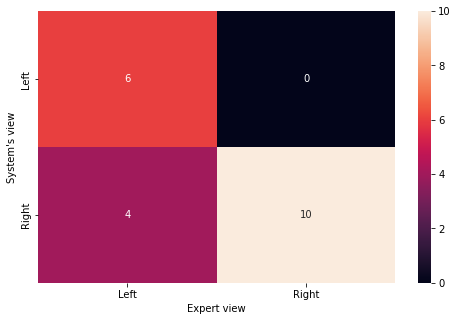

Precision:  0.8571428571428572
Recall:  0.8
F1_score:  0.8275862068965518
----------------------EXPERIMENT 7---------------------------
Mean test rates:
[76. 60. 54. 50. 48. 47. 47. 47. 47. 47.]
[47. 47. 47. 47. 48. 49. 50. 54. 62. 77.]


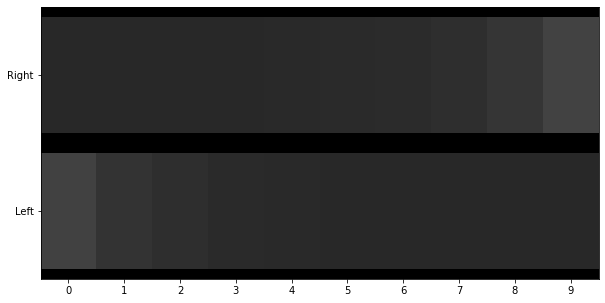

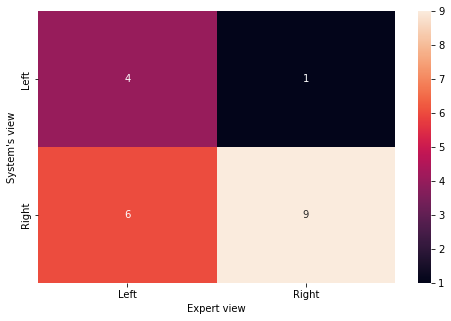

Precision:  0.7
Recall:  0.65
F1_score:  0.6740740740740739
----------------------EXPERIMENT 8---------------------------
Mean test rates:
[69. 58. 53. 50. 50. 49. 49. 48. 48. 48.]
[49. 49. 49. 49. 50. 50. 51. 54. 59. 70.]


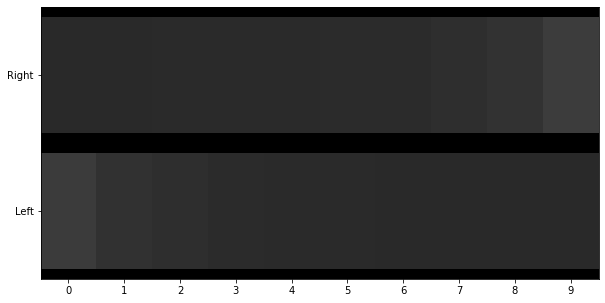

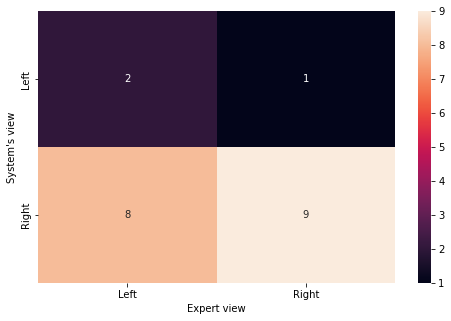

Precision:  0.5980392156862745
Recall:  0.55
F1_score:  0.5730145175064049
----------------------EXPERIMENT 9---------------------------
Mean test rates:
[64. 56. 53. 51. 50. 50. 50. 50. 50. 50.]
[50. 50. 50. 50. 51. 51. 52. 54. 57. 65.]


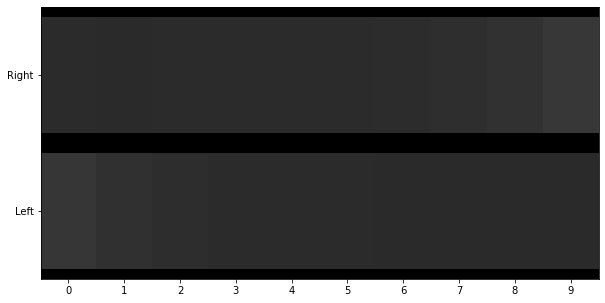

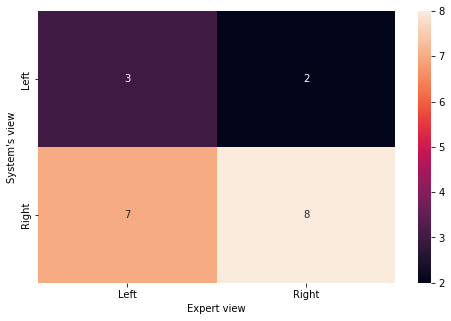

Precision:  0.5666666666666667
Recall:  0.55
F1_score:  0.5582089552238807
----------------------EXPERIMENT 10---------------------------
Mean test rates:
[60. 55. 53. 51. 51. 51. 50. 50. 50. 50.]
[51. 51. 51. 51. 51. 51. 52. 53. 56. 61.]


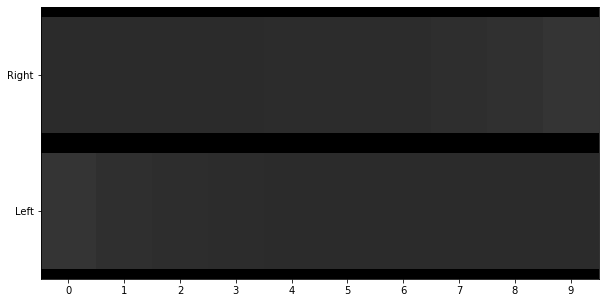

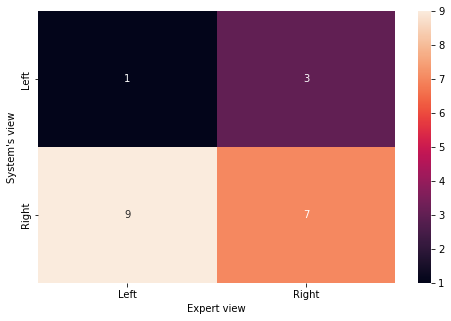

Precision:  0.34375
Recall:  0.39999999999999997
F1_score:  0.3697478991596639


In [ ]:
%matplotlib inline
b2.start_scope()

def analyse(pred, labels):
    n = len(pred)
    LL = LR = RL = RR = 0
    for k in range(n):
        if (pred[k] == labels[k] and pred[k] == "left"):
            LL += 1
        if (pred[k] == labels[k] and pred[k] == "right"):
            RR += 1
        if (pred[k] != labels[k] and pred[k] == "left"):
            LR += 1
        if (pred[k] != labels[k] and pred[k] == "right"):
            RL += 1
    conf_matr = np.array([[LL, LR], [RL, RR]])
    show_confusion_matrix(conf_matr, "Expert view", "System's view") # матрица неточностей
    if np.linalg.det(conf_matr) == 0: 
        precision = 0
    else:
        precision_left = LL/(LL+LR)
        precision_right = RR/(RL+RR)
        precision = (precision_left+precision_right)/2
    recall_left = LL/(LL+RL)
    recall_right = RR/(RR+LR)
    recall = (recall_left+recall_right)/2
    if LL == RR == 0:
        F1_score = 0
    else:
        F1_score = 2*precision*recall/(precision+recall)
    return precision, recall, F1_score 

def show_confusion_matrix(conf_matr, xlabel, ylabel, annotate=True):
    df_cm = pd.DataFrame(conf_matr, index = [k for k in range(conf_matr.shape[0])],
              columns = [k for k in range(conf_matr.shape[1])])
    plt.figure(figsize = (8,5))
    ax = plt.axes()
    sn.heatmap(df_cm, annot=annotate, ax=ax)
    ax.set_xticks([0.5, 1.5], ["Left", "Right"])
    ax.set_yticks([0.5, 1.5], ["Left", "Right"])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

def draw_intensity(intensity_samples, minI, maxI):
    x = np.arange(-0.5, ni, 1)
    y = np.arange(-0.5, 2, 1)
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_xticks(range(ni))
    ax.set_yticks([0, 1], ["Left", "Right"])
    ax.pcolormesh(x, y, intensity_samples, cmap='gray', vmin=minI, vmax=maxI)
    #for k in x:
      #plt.axvline(k, ls='-', c='w', lw=4) # white line between bars
    for k in y:
      plt.axhline(k, ls='-', c='black', lw=20)

def predict(test_rates, classes):
    pred = []
    for rates_sample in test_rates:
        spike_num = test(rates_sample)
        if spike_num[0] > spike_num[1]: 
            pred += [classes[0]]
        else:
            pred += [classes[1]]
    return pred

def decrease_contrast(current_test_rates, coef):
    for k in range(n_test):
        rates_sample = current_test_rates[k]
        new_rates_sample = coef*rates_sample + (1-coef)*sum(rates_sample)/ni
        current_test_rates[k] = new_rates_sample


snn = SNN(ni, 0)
test_rates = np.hstack([test_left_rates, test_right_rates]).reshape(n_test, ni)
labels = ["left", "right"]*(n_test//2)

for k in range(10):
    print(f"----------------------EXPERIMENT {k+1}---------------------------")
    print("Mean test rates:")
    mean_test_rate_left = np.mean(test_rates[0:n_test-1:2], axis = 0)
    mean_test_rate_right = np.mean(test_rates[1:n_test:2], axis = 0)
    print(mean_test_rate_left//1)
    print(mean_test_rate_right//1)
    draw_intensity(np.vstack((mean_test_rate_left, mean_test_rate_right)), min_rate, max_rate)
    pred = predict(test_rates, classes)
    precision, recall, F1_score = analyse(pred, labels)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1_score: ", F1_score) # F1 мера (сбалансированная мера)
    decrease_contrast(test_rates, 0.7)


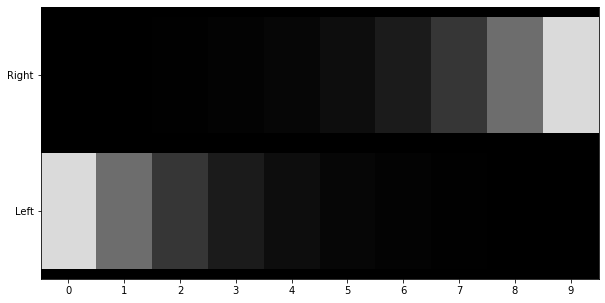

In [ ]:
left_intensity = [256, 128, 64, 32, 16, 8, 4, 2, 1, 0]
right_intensity = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256]
draw_intensity(np.vstack((left_intensity, right_intensity)), min_rate, max_rate)

----------------------EXPERIMENT 6---------------------------
Mean test rates:
[58. 54. 53. 52. 51. 51. 51. 51. 51. 51.]
[51. 51. 52. 52. 52. 52. 52. 53. 55. 59.]


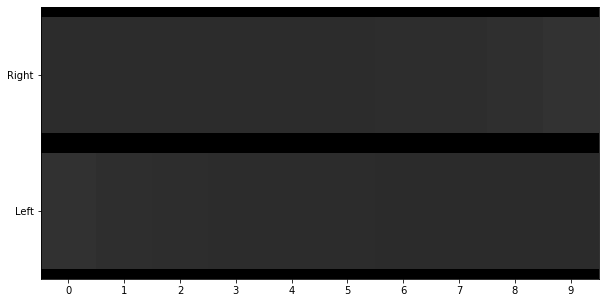

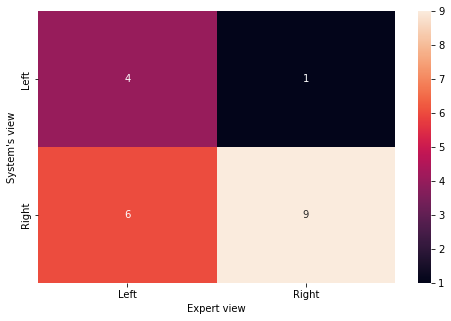

Precision:  0.7
Recall:  0.65
F1_score:  0.6740740740740739
----------------------EXPERIMENT 7---------------------------
Mean test rates:
[56. 54. 53. 52. 52. 51. 51. 51. 51. 51.]
[52. 52. 52. 52. 52. 52. 52. 53. 54. 57.]


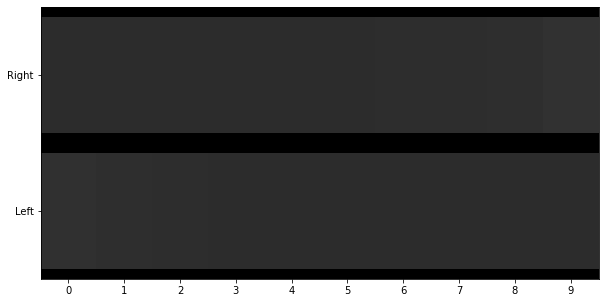

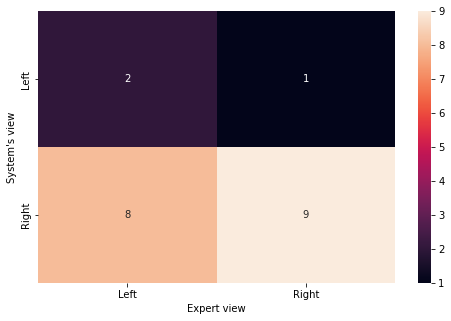

Precision:  0.5980392156862745
Recall:  0.55
F1_score:  0.5730145175064049
----------------------EXPERIMENT 8---------------------------
Mean test rates:
[55. 53. 52. 52. 52. 52. 52. 52. 52. 52.]
[52. 52. 52. 52. 52. 52. 53. 53. 54. 56.]


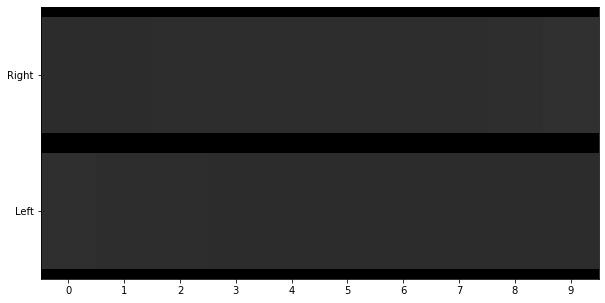

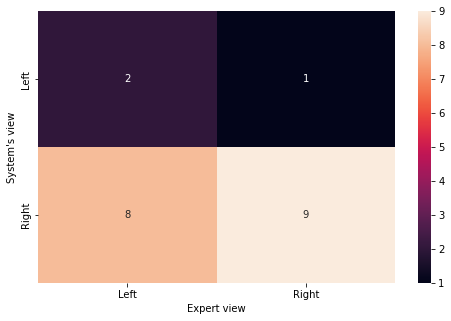

Precision:  0.5980392156862745
Recall:  0.55
F1_score:  0.5730145175064049
----------------------EXPERIMENT 9---------------------------
Mean test rates:
[54. 53. 52. 52. 52. 52. 52. 52. 52. 52.]
[52. 52. 52. 52. 53. 53. 53. 53. 54. 55.]


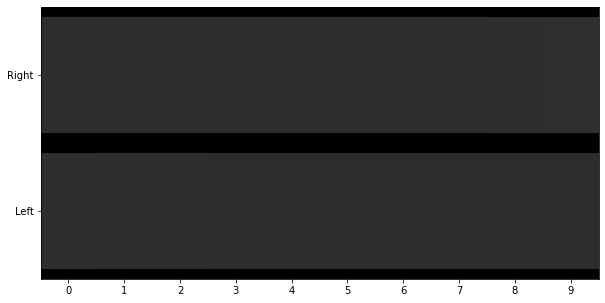

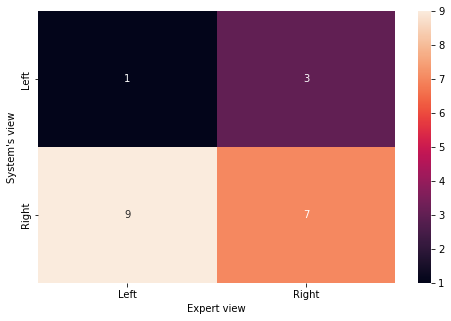

Precision:  0.34375
Recall:  0.39999999999999997
F1_score:  0.3697478991596639
----------------------EXPERIMENT 10---------------------------
Mean test rates:
[54. 53. 52. 52. 52. 52. 52. 52. 52. 52.]
[53. 53. 53. 53. 53. 53. 53. 53. 53. 54.]


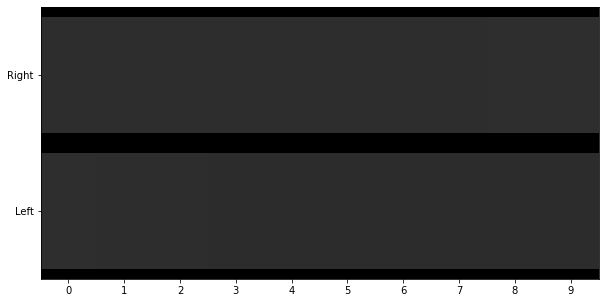

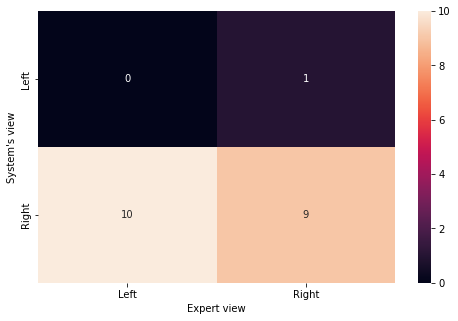

Precision:  0.23684210526315788
Recall:  0.45
F1_score:  0.3103448275862069


In [ ]:
for k in range(5):
    print(f"----------------------EXPERIMENT {k+6}---------------------------")
    print("Mean test rates:")
    mean_test_rate_left = np.mean(test_rates[0:n_test-1:2], axis = 0)
    mean_test_rate_right = np.mean(test_rates[1:n_test:2], axis = 0)
    print(mean_test_rate_left//1)
    print(mean_test_rate_right//1)
    draw_intensity(np.vstack((mean_test_rate_left, mean_test_rate_right)), min_rate, max_rate)
    pred = predict(test_rates, classes)
    precision, recall, F1_score = analyse(pred, labels)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1_score: ", F1_score) # F1 мера (сбалансированная мера)
    decrease_contrast(test_rates, 0.7)

Text(0.5, 1.0, 'F1-score curve')

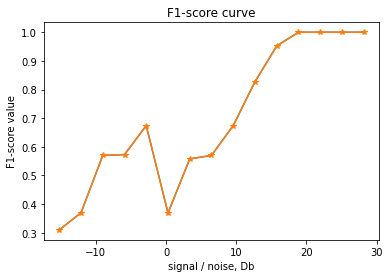

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
acc_f1 = np.array([1.0, 1.0, 1.0, 1.0, 0.952, 0.827, 0.674, 0.57, 0.558, 0.369, 0.674, 0.573, 0.57, 0.37, 0.31])
axes_x = np.array([20*math.log10(256*(0.7**i)/10) for i in range(15)])
plt.plot(axes_x, acc_f1)
plt.plot(axes_x, acc_f1, marker = '*')
plt.xlabel("signal / noise, Db")
plt.ylabel("F1-score value")
plt.title("F1-score curve")